<h1><center>Denoising Documents with Computer Vision and Digital Image Processing</center></h1>

<center><img src="assets/denoise.png"></center>


<div class="list-group" id="list-tab" role="tablist">
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0; color:white' role="tab" aria-controls="home"><center>Quick navigation</center></h2>

* [1. Description](#1)
* [2. Requirements](#2)
* [3. Median Filtering](#3)
* [4. AutoEncoder](#4)
* [5. References](#5)

<a id="1"></a>
<h2 style='background:black; border:0; color:white'><center>1. Description</center><h2>

Many image processing applications make use of digitalized textual data. However, the presence of any type of noise can create difficulties in post-processing information, such as on OCR detection. To improve the information manipulation on such data, a previous image processing step is required.

In light of this idea, a set of text paragraphs containing plain English language was collected. Different font styles, size, and background noise level were arranged to simulate the a variety of scenarios.

The objective of this test is to evaluate the possible image processing methods that could fix the text samples. Note that the samples have a different type of background noise and present a set of text fonts. Therefore, the candidate should provide a flexible algorithm that can correctly detect what is text characters and background noise, offering a clean version of each text paragraph as result.

<a id="2"></a>
<h2 style='background:black; border:0; color:white'><center>2. Requirements</center><h2>

Assuming that you have a clean enviroment to run this jupyter notebook, create a new code block, copy and paste the following code and run it:

```py
!pip install numpy
!pip install scipy
!pip install pillow
!pip install opencv-python
!pip install matplotlib
!pip install tensorflow
!pip install scikit-learn
```

In [1]:
########################################################
from os import listdir
from os.path import isfile, join
########################################################
import numpy as np
from scipy import signal
from PIL import Image
import cv2
import matplotlib.pyplot as plt
########################################################
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model, layers
from sklearn.model_selection import train_test_split
########################################################
# Comment the following code if you don't have tensorflow-gpu installed in your enviroment
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPU is available


<a id="3"></a>
<h2 style='background:black; border:0; color:white'><center>3. Median Filtering</center><h2>

A simple way to solve this problem is using classic digital image processing techniques since it will not be necessary to train any machine learning algorithms, which usually require more data, time, and better hardware. So, as a first answer, I will apply the median filter to get the background of the image, then I will subtract it from the original image.

In [18]:
class Denoiser:
    """
    Class that creates and object capable of colect dirty images and partially clean some of its noise
    """
    
    def __init__(self):
        self.input_image = None
        self.output_image = None
    
    def load_image(self, path):
        # Load an image from the path and return it as a numpy array
        return np.asarray(Image.open(path))/255.0
    
    def save_image(self, dest_path, image):
        #  Take some image array(image) and save it in the destination(dest_path)
        img_arr = np.asarray(image*255.0, dtype=np.uint8)
        Image.fromarray(img_arr).save(dest_path)
        
    def denoiser_pipeline(self, image):
        # Collect background
        background = signal.medfilt2d(image, 11)
        # Select anything that is darker than the background
        foreground_mask = image < background - 0.1
        # Return black for anything that is darker than the background or white otherwise
        output_image = np.where(foreground_mask, 0.0, 1.0)
        
        return output_image
        
    def clean(self, image_path, dest_path):
        # Load the input image
        self.input_image = self.load_image(image_path)
        # Process the image and load it in the output
        self.output_image = self.denoiser_pipeline(self.input_image)
        # Saves the output
        self.save_image(dest_path, self.output_image)
        
    def show(self):
        # Show the last image filtered in a kernel
        in_img = np.asarray(self.input_image*255.0, dtype = np.uint8)
        out_img = np.asarray(self.output_image*255.0, dtype = np.uint8)
        
        fig , axs = plt.subplots(1,2, figsize = (16,16))
        axs[0].imshow(Image.fromarray(in_img), cmap = 'gray')
        axs[1].imshow(Image.fromarray(out_img), cmap = 'gray')
        axs[0].axis('off')
        axs[1].axis('off')
        plt.show()

In [19]:
input_datapath = 'noisy_data/'
output_datapath = 'output_median/'

files = [f for f in listdir(input_datapath) if isfile(join(input_datapath, f))]

denoiser = Denoiser()

for f in files:
    
    denoiser.clean(input_datapath + f, output_datapath + f)

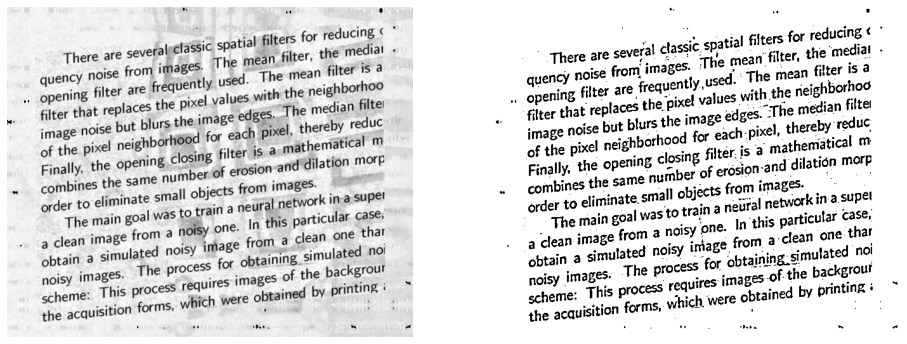

In [20]:
denoiser.show()

Analyzing the processed images is possible to see that the algorithm works relatively well, considering its simplicity. It is possible to use it in scenarios without many resources to use more sophisticated and modern solutions. 

The results are available in the output_median directory.

<a id="4"></a>
<h2 style='background:black; border:0; color:white'><center>4. AutoEncoder</center><h2>

A more sophisticated answer to the problem is using the "magic" of Deep Learning. For this, I will use an Autoencoder network, which is composed of an encoder and a decoder. The encoder compresses the data to a smaller representation. The decoder reconstructs this representation to obtain an output close to the input. During the process, the autoencoder learns the most important features that make up the data. 

Autoencoders can reduce image noise by providing noisy data as an input and outputting the same data without noise. Then, the autoencoder can learn how to filter similar data efficiently. 

But how is it possible to apply this to the proposed problem? 

As stated in the test description, cleaning document images is a well-documented problem. Then it is possible to find databases that provide images with background noise and their respective clean version with ease. After looking for a database that fits the task, I trained an autoencoder using its dirty data as input and its clean images as output. So, I used the network to filter the dirty inputs presented by the challenge.

In [5]:
# Simple image process to standardize our data
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (420, 540, 1))
    
    return img

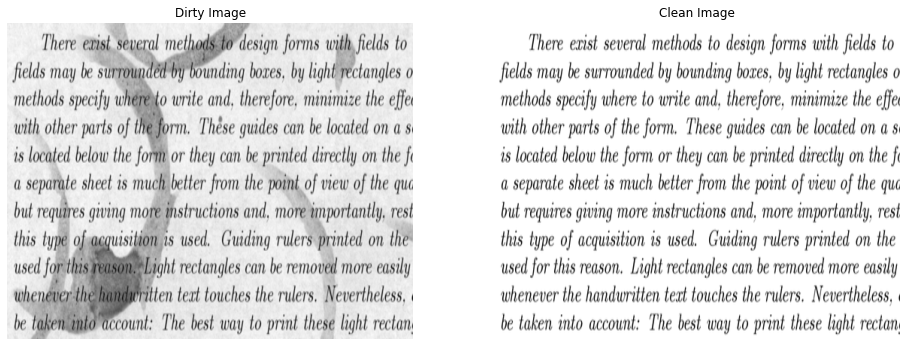

Size of X :  (144, 420, 540, 1)
Size of Y :  (144, 420, 540, 1)


In [6]:
# Loading the training images
noisy_path = 'train/'
clean_path = 'train_cleaned/'
test_path = 'test/'

noisy_dir = listdir(noisy_path)
x_paths = [noisy_path+x for x in noisy_dir]

clean_dir = listdir(clean_path)
y_paths = [clean_path+y for y in clean_dir]

size = (420,540)

#cleaned_images = [(np.asarray(Image.open(y).convert('L').resize(size)).astype('float32')/255.0).reshape(420,540,1) for y in y_paths]
#dirty_images = [(np.asarray(Image.open(x).convert('L').resize(size)).astype('float32')/255.0).reshape(420,540,1) for x in x_paths]

X = []
y = []

for image in x_paths:
    
    img = process_image(image)
    X.append(img)

for label in y_paths:
    
    img = process_image(label)
    y.append(img)
    


X = np.array(X)
y = np.array(y)


fig, axs = plt.subplots(1,2, figsize = (16,16))

axs[0].set_title('Dirty Image')
axs[0].imshow(X[0][:,:,0], cmap = 'gray')
axs[0].axis('off')

axs[1].set_title('Clean Image')
axs[1].imshow(y[0][:,:,0], cmap = 'gray')
axs[1].axis('off')

plt.show()


print("Size of X : ", X.shape)
print("Size of Y : ", y.shape)

For the construction of the autoencoder, I will use: 

- Convolutional layers to extract the significant features of the images; 
- Max-pooling for data compression; 
- Up-sampling for restoring the data dimension;
- Batch normalization to reduce the difference in the distribution of activations between the layers.

In [7]:
def autoencoder():
    
    
    input_layer = layers.Input(shape=(420,540,1), name= 'Image_Input')
    
    # Encoder
    
    x = layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same', name = 'Convolutional_Layer_1')(input_layer)
    x = layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same', name = 'Convolutional_Layer_2')(x)
    #x = layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same', name = 'Convolutional_Layer_3')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.MaxPooling2D((2,2), padding = 'same', name='Pooling_Layer_3')(x)
    
    #x = layers.Dropout(0.5)(x)
    
    # Decoder
    #x = layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same', name = 'Convolutional_Layer_4')(x)
    x = layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same', name = 'Convolutional_Layer_5')(x)
    x = layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same', name = 'Convolutional_Layer_6')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.UpSampling2D((2,2), name = 'UpSampling_Layer_3')(x)
    
    #x = layers.Dropout(0.3)(x)
    output_layer = layers.Conv2D(1, (3,3), activation = 'sigmoid', padding = 'same', name = 'Convolutional_Layer_7')(x)
    
    # Model
    
    autoencoder = Model(inputs = [input_layer], outputs = [output_layer])
    autoencoder.compile(optimizer = 'adam', loss='mean_squared_error', metrics=['mae'])
    
    return autoencoder

In [8]:
ae = autoencoder()
ae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_Input (InputLayer)     [(None, 420, 540, 1)]     0         
_________________________________________________________________
Convolutional_Layer_1 (Conv2 (None, 420, 540, 32)      320       
_________________________________________________________________
Convolutional_Layer_2 (Conv2 (None, 420, 540, 64)      18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 420, 540, 64)      256       
_________________________________________________________________
Pooling_Layer_3 (MaxPooling2 (None, 210, 270, 64)      0         
_________________________________________________________________
Convolutional_Layer_5 (Conv2 (None, 210, 270, 64)      36928     
_________________________________________________________________
Convolutional_Layer_6 (Conv2 (None, 210, 270, 32)      18464 

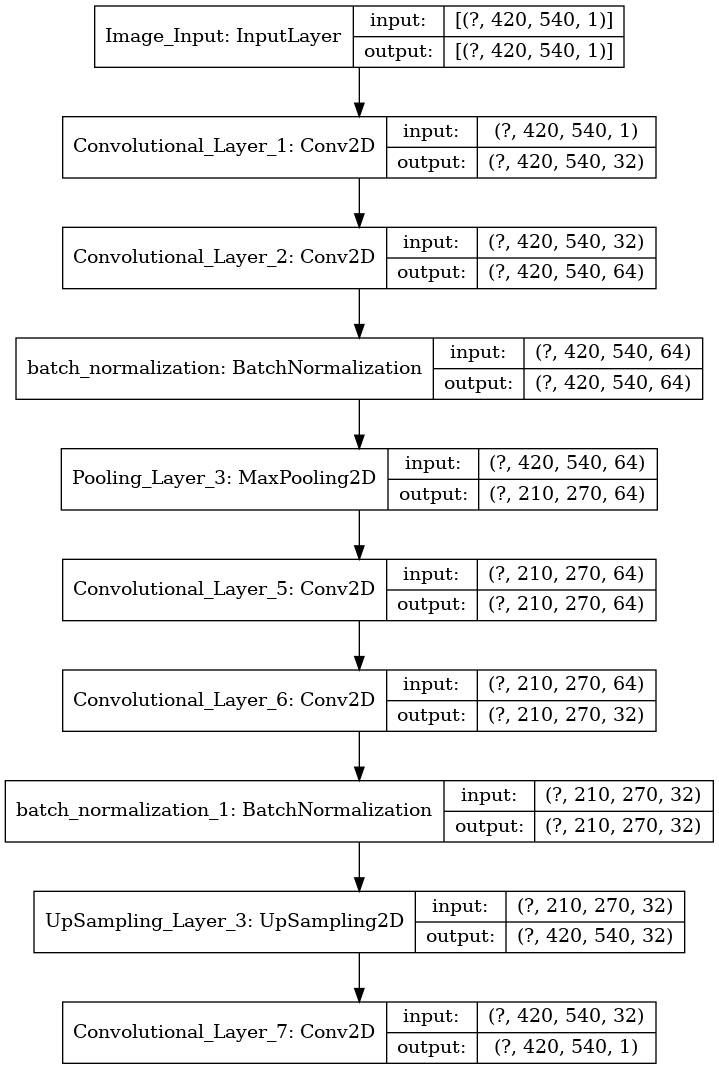

In [9]:
keras.utils.plot_model(ae, "assets/autoencoder.png", show_shapes=True)

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=0)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)


In [11]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=20)

hist = ae.fit(X_train, y_train, epochs=50, batch_size=2, validation_data=(X_valid, y_valid), callbacks = [callback])

Epoch 1/50
65/65 [==============================] - 31s 480ms/step - loss: 0.0592 - mae: 0.1774 - val_loss: 0.0740 - val_mae: 0.2315
Epoch 2/50
65/65 [==============================] - 3s 50ms/step - loss: 0.0189 - mae: 0.0936 - val_loss: 0.0652 - val_mae: 0.1574
Epoch 3/50
65/65 [==============================] - 3s 50ms/step - loss: 0.0095 - mae: 0.0646 - val_loss: 0.0655 - val_mae: 0.1346
Epoch 4/50
65/65 [==============================] - 3s 50ms/step - loss: 0.0066 - mae: 0.0500 - val_loss: 0.0625 - val_mae: 0.1209
Epoch 5/50
65/65 [==============================] - 3s 50ms/step - loss: 0.0049 - mae: 0.0434 - val_loss: 0.0572 - val_mae: 0.1093
Epoch 6/50
65/65 [==============================] - 3s 50ms/step - loss: 0.0037 - mae: 0.0390 - val_loss: 0.0534 - val_mae: 0.1016
Epoch 7/50
65/65 [==============================] - 3s 50ms/step - loss: 0.0025 - mae: 0.0327 - val_loss: 0.0307 - val_mae: 0.0809
Epoch 8/50
65/65 [==============================] - 3s 50ms/step - loss: 0.0021 -

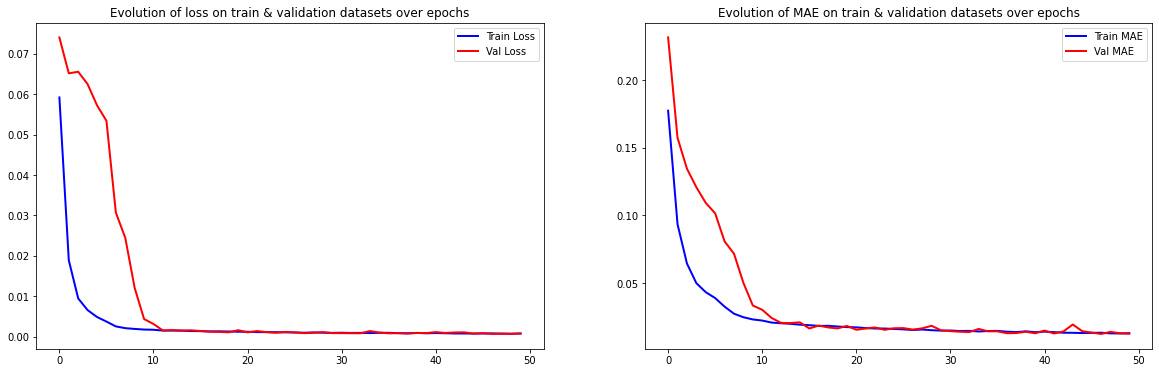

In [12]:
epoch_loss = hist.history['loss']
epoch_val_loss = hist.history['val_loss']
epoch_mae = hist.history['mae']
epoch_val_mae = hist.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

The neural network seems to have learned to solve the problem well for the data sample provided so far, as you can see in the graphs. 

However, this does not mean that the network has learned well for images it has never seen, different noises, rotated texts. 

Then we will test the images on the noisy data provided by the test to check if the algorithm used was efficient.

In [13]:
test_path = 'noisy_data/'
test_dir = listdir(test_path)
test_paths = [test_path+x for x in test_dir]

X_test = []
for image in test_paths:
    
    img = process_image(image)
    X_test.append(img)
    
X_test = np.array(X_test)
print(X_test.shape)

(144, 420, 540, 1)


In [14]:
Y_test = ae.predict(X_test, batch_size=4)

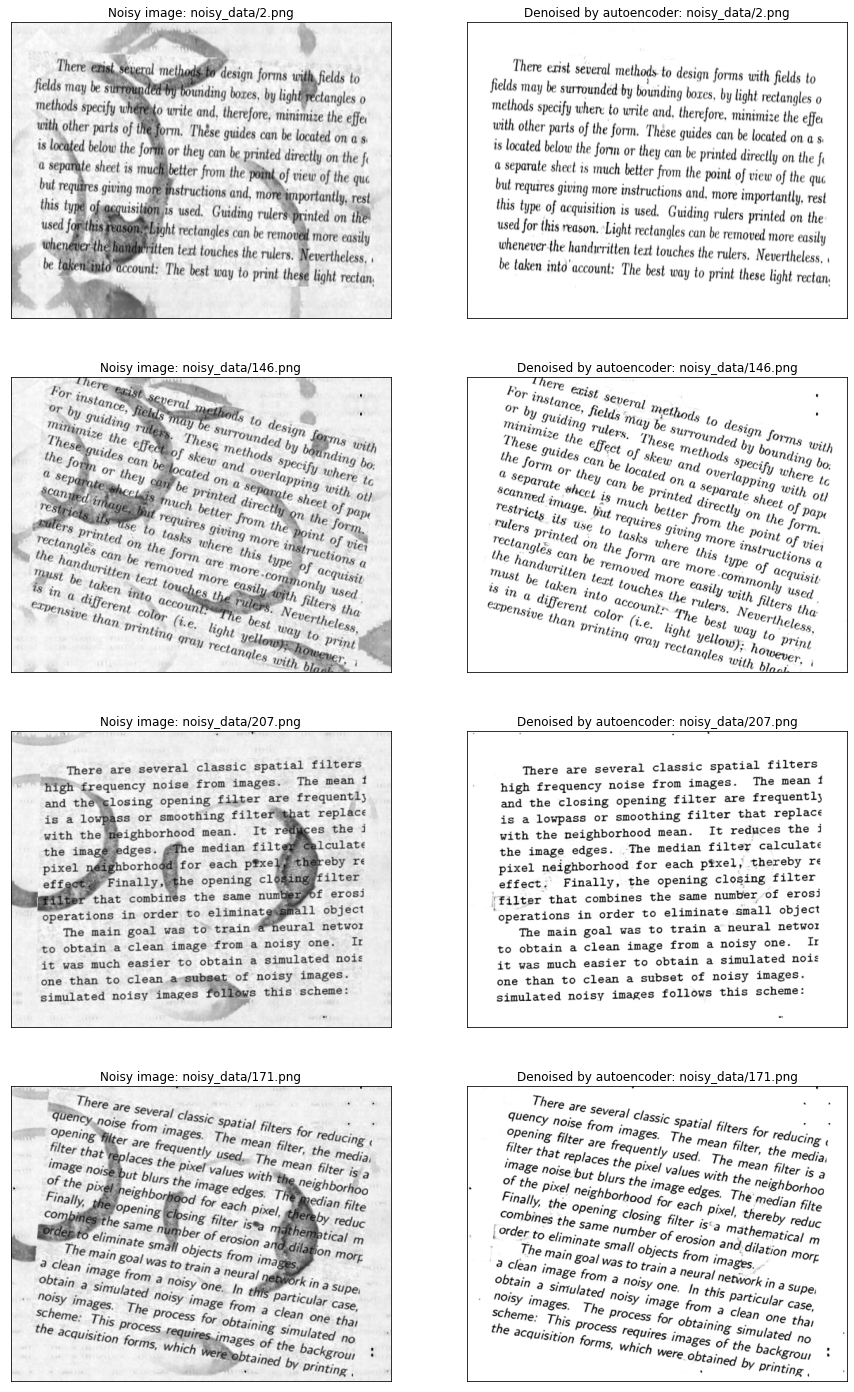

In [15]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_paths[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_paths[i]))

plt.show()

In [17]:
for i in range(len(test_dir)):
    
    img = cv2.imread('noisy_data/'+test_dir[i],0)
    img_shape = img.shape
    
    output_reshaped = cv2.resize(np.uint8(Y_test[i]*255), (img_shape[1],img_shape[0]))
    
    cv2.imwrite(f'output_ae/{test_dir[i]}', output_reshaped)

As you can see in the images above, the approached strategy was very efficient in removing the noise from the data provided. It seems that the model has learned to distinguish the background from the images well, even with different types of noise and rotated texts. 

All the results are available at the output_ae directory.

<a id="5"></a>
<h2 style='background:black; border:0; color:white'><center>5. References</center><h2>

* [Denoising Dirty Documents Kaggle Competition](https://www.kaggle.com/c/denoising-dirty-documents)
* [Denoising with AutoEncoders - T81-558: Applications of Deep Neural Networks](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_14_02_auto_encode.ipynb)
* [Denoise images using Autoencoder[TF, Keras] ](https://www.kaggle.com/michalbrezk/denoise-images-using-autoencoders-tf-keras)